# Notebook for speaker recognition

### Install & import libraries

In [15]:
# !pip install tensorflow
# !pip install tensorflow-datasets
# !pip install tensorflow-io
# !pip install tensorflow-addons
# !pip install librosa

In [16]:
from sklearn.model_selection import train_test_split

from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import numpy as np

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from keras.models import Sequential
import tensorflow_addons as tfa
from plot_keras_history import plot_history

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


### Librispeech dataset

In [17]:
# import tensorflow_datasets as tfds

# ds = tfds.load('librispeech', split='dev_clean',builder_kwargs={'config': 'lazy_decode'})

### Navigate to path of dataset

In [18]:
%cd C:\Users\Gerard\tensorflow_datasets\dev-clean

C:\Users\Gerard\tensorflow_datasets\dev-clean


In [19]:
import os

cwd = os.getcwd()

os.listdir(cwd)

listaudio = [] #list of audiofiles per speaker
listpath = [] #list of speakers (path)
listcat = [] #list of speakers

for i,v in enumerate(os.listdir(cwd)):
    path1 = os.path.join(cwd,v)
    path2 = os.path.join(path1,os.listdir(path1)[0])
    listpath.append(path2)
    listaudio.append(os.listdir(path2))
    listcat.append(v)

# No. of speakers
num_class = len(listcat)
print("Number of speakers:")
print(num_class)

Number of speakers:
40


### Convert audio files to MFCC features

In [20]:
import librosa
import numpy as np

ylen = []
y_data = []

samplenum = 10

for i,v in enumerate(listpath):
    num = 0    
    for j,k in enumerate(listaudio[i]):        
        if j != (len(listaudio[i])-1):
            filename = os.path.join(v,k)
            y, sr = librosa.load(filename, sr=16000)
            if y.shape[0]>48000 and num<samplenum:
                y1 = y[:48000]
                mfccvec = librosa.feature.mfcc(y=y1, sr=sr)
                num = num + 1
                ylen.append(mfccvec)
                y_data.append(listcat[i])
        


X_data = np.array(ylen)
print('Shape of X_data: ')
print(X_data.shape)
print('Number of X_data samples: ')
print(X_data.shape[0])
print('MFCC shape: ')
print(X_data.shape[1:3])
print('Number of y_data labels: ')
print(len(y_data))

Shape of X_data: 
(395, 20, 94)
Number of X_data samples: 
395
MFCC shape: 
(20, 94)
Number of y_data labels: 
395


### One-hot transformation for multiclass

In [21]:
def onehot_transform(y_data):
    onehot_encoder = OneHotEncoder(sparse=False)
    y_data_onehot = onehot_encoder.fit_transform(np.array(y_data).reshape(-1, 1))
    return y_data_onehot

### Split dataset into train and test

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=2, stratify = y_data)

y_train_onehot = onehot_transform(y_train)
y_test_onehot = onehot_transform(y_test)

C:\Users\Gerard\anaconda3\envs\omdena2\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\Gerard\anaconda3\envs\omdena2\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Build model

In [23]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(20,94,1)),)
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),)
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(num_class, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
                      metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 94, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 47, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 10, 47, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 47, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 23, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 23, 32)         0

### Train model

Epoch 1/20
79/79 [==============================] - 1s 6ms/step - loss: 8.8055 - accuracy: 0.0348
Epoch 2/20
79/79 [==============================] - 0s 6ms/step - loss: 2.9862 - accuracy: 0.1709
Epoch 3/20
79/79 [==============================] - 0s 6ms/step - loss: 1.5925 - accuracy: 0.5538
Epoch 4/20
79/79 [==============================] - 0s 6ms/step - loss: 0.6099 - accuracy: 0.8006
Epoch 5/20
79/79 [==============================] - 0s 6ms/step - loss: 0.2644 - accuracy: 0.9082
Epoch 6/20
79/79 [==============================] - 0s 6ms/step - loss: 0.1681 - accuracy: 0.9494
Epoch 7/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0489 - accuracy: 0.9842
Epoch 8/20
79/79 [==============================] - 1s 6ms/step - loss: 0.0444 - accuracy: 0.9842
Epoch 9/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0283 - accuracy: 0.9905
Epoch 10/20
79/79 [==============================] - 0s 6ms/step - loss: 0.0654 - accuracy: 0.9778
Epoch 11/20
79/79 [

(<Figure size 1000x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

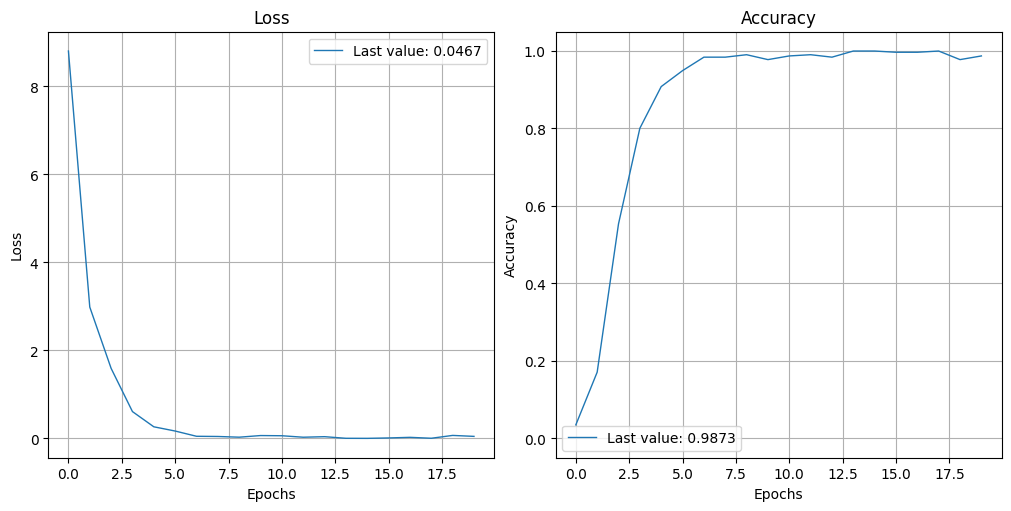

In [24]:
hist = model.fit(X_train, y_train_onehot,
                            epochs=20,
                            verbose=True,
                            batch_size=4).history

loss, accuracy = model.evaluate(X_train, y_train_onehot, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test_onehot, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(hist)

In [25]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax(y_prediction, axis = 1)
print("Predicted labels:")
print(y_prediction)

y_test1 = np.argmax(y_test_onehot, axis = 1)
print("Actual labels:")
print(y_test1)

confmat = confusion_matrix(y_test1, y_prediction)
print("Confusion matrix:")
print(confmat)

accscore = accuracy_score(y_test1,y_prediction)
print("Accuracy:")
print(accscore)

3/3 [==============================] - 0s 5ms/step
Predicted labels:
[36 35  5 15  2 14 15  1 35  5 16 21 19 27  5 11 20  4 18  1  5 16 14  2
 32 31 10 26 31 16  7 23 36 30 11 31 31 18 14  5  6 27 30 11 39 14  5 35
 37 29  3 23  0 13 30  0 18 37 12 29 25 17  3 18 34  4 20 13 35 20  1 18
  6 32 25 20 24 32 27]
Actual labels:
[36  8 28 15  2 17 15 24  4 22 16 21 19 27 39 11 38 26 18  7 22 37  4  2
 35  3 10 34 12 16  7 23 36 30 11  5 19 10  9 31  6 28 31  5 14 33 33 35
 37 29  3 23  0 13 30  0 18 38 12 29 25 17 14 26 34 20 39 13  1  8  1 21
  6 32 25 20 24 32 27]
Confusion matrix:
[[2 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 2 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy:
0.5443037974683544
